In [26]:
import pandas as pd 

#load datasets
customers = pd.read_csv('../ecommerce-analysis/data/Customers.csv')
products = pd.read_csv('../ecommerce-analysis/data/Products.csv')
transactions = pd.read_csv('../ecommerce-analysis/data/Transactions.csv')

merged = pd.merge(transactions, customers , on='CustomerID', how='left')
print(merged.head)

<bound method NDFrame.head of     TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0          T00001      C0199      P067  2024-08-25 12:38:23         1   
1          T00112      C0146      P067  2024-05-27 22:23:54         1   
2          T00166      C0127      P067   2024-04-25 7:38:55         1   
3          T00272      C0087      P067  2024-03-26 22:55:37         2   
4          T00363      C0070      P067  2024-03-21 15:10:10         3   
..            ...        ...       ...                  ...       ...   
995        T00496      C0118      P037   2024-10-24 8:30:27         1   
996        T00759      C0059      P037   2024-06-04 2:15:24         3   
997        T00922      C0018      P037  2024-04-05 13:05:32         4   
998        T00959      C0115      P037  2024-09-29 10:16:02         2   
999        T00992      C0024      P037  2024-04-21 10:52:24         1   

     TotalValue   Price          CustomerName         Region  SignupDate  
0        300.68  3

In [27]:
from datetime import datetime

#calculate days since signup
merged['SignupDate'] = pd.to_datetime(merged['SignupDate'])
latest_date = merged['TransactionDate'].max()
merged['Tenure'] = (pd.to_datetime(latest_date) - merged['SignupDate']).dt.days

customer_features = merged.groupby('CustomerID').agg(
    Region = ("Region", 'first'),
    Tenure = ('Tenure', 'first'),
    TotalSpent = ('TotalValue', 'sum'), 
    PurchaseFrequency = ('TransactionID','count'), 
    AvgTransactionValue = ('TotalValue','mean'),
).reset_index()

In [28]:
from sklearn.preprocessing import OneHotEncoder

# One-hot encode 'Region'
encoder = OneHotEncoder()
encoded = encoder.fit_transform(customer_features[["Region"]])
encoded_df = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out())

In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numerical_features = customer_features[["Tenure", "TotalSpent", "PurchaseFrequency", "AvgTransactionValue"]]
scaled_features = scaler.fit_transform(numerical_features)
scaled_df = pd.DataFrame(scaled_features, columns = numerical_features.columns)

In [30]:
final_features = pd.concat([encoded_df, scaled_df], axis=1)

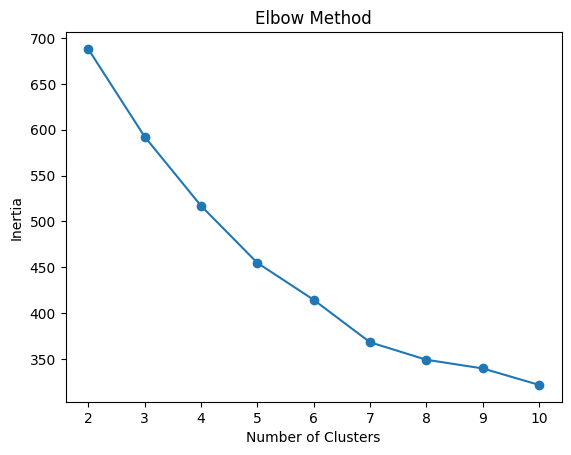

10


In [31]:
#determining optimal clusters using elbow method

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

#calculate inertia for cluster numbers
inertia = []
for k in range(2,11):
    kmeans = KMeans(n_clusters = k, random_state = 42)
    kmeans.fit(final_features)
    inertia.append(kmeans.inertia_)

#Plotting the elbow curve
plt.plot(range(2,11), inertia, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

print(k)

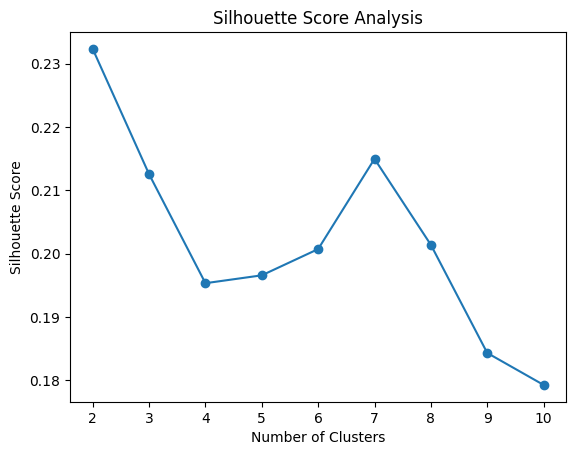

10


In [32]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(final_features)
    score = silhouette_score(final_features, clusters)
    silhouette_scores.append(score)

plt.plot(range(2, 11), silhouette_scores, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score Analysis")
plt.show()

print(k)

In [33]:
#Training the clustering model
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(final_features)
customer_features['Cluster'] = clusters 



In [34]:
#calculating DB Index

from sklearn.metrics import davies_bouldin_score

db_score = davies_bouldin_score(final_features, clusters)
print(f"Davies-Bouldin Index: {db_score}")

Davies-Bouldin Index: 1.456986631969501


In [35]:
cluster_summary = customer_features.groupby("Cluster").agg({
    'TotalSpent':'mean',
    'PurchaseFrequency':'mean',
    'AvgTransactionValue':'mean',
    'Region':lambda x: x.mode()[0],
}).reset_index()
print(cluster_summary)

   Cluster   TotalSpent  PurchaseFrequency  AvgTransactionValue         Region
0        0  6086.011364           8.363636           730.609726  South America
1        1  2826.154583           4.500000           630.461688  South America
2        2  4940.102500           4.500000          1106.602746  South America
3        3  1996.472188           3.187500           631.349563         Europe
4        4  2426.630625           2.437500           991.220104           Asia
5        5   671.011875           2.375000           276.510594         Europe
6        6  3086.289000           5.750000           550.257768  South America
7        7  4379.285385           5.384615           815.302179         Europe
8        8  5796.247500           6.750000           873.800380         Europe
9        9  3373.480833           6.458333           532.406682  North America


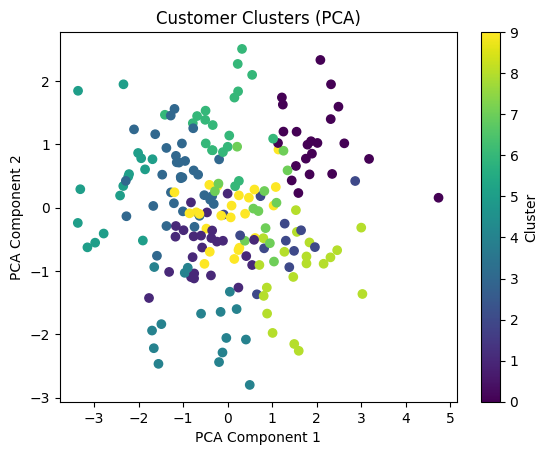

In [36]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
pca_result = pca.fit_transform(final_features)

plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap="viridis")
plt.title("Customer Clusters (PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()

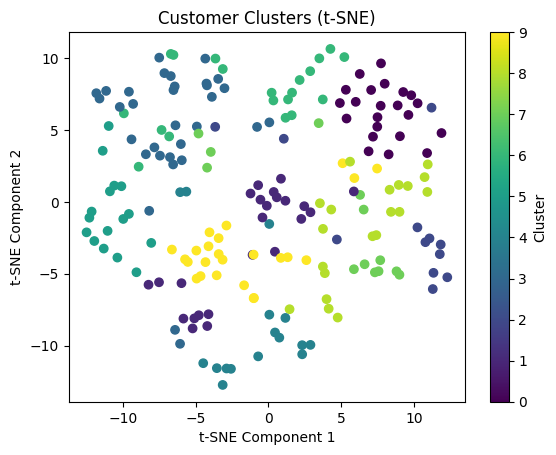

In [37]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(final_features)

plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=clusters, cmap="viridis")
plt.title("Customer Clusters (t-SNE)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(label="Cluster")
plt.show()